In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sps
import time
import tqdm
import copy

### Exercise 28

For notation, we have: 
\begin{equation*}
    \pi = \mathcal{N}(0,\sigma^2) \ \ \ \pi' = \mathcal{N}(0,1)
\end{equation*}

\begin{equation*}
    \omega (x) = \dfrac{\pi}{\pi'} = \dfrac{1}{\sigma} e^{x^2/2-x^2/2\sigma^2}
\end{equation*}

We would then implement the resampling methods (multinomial, Bernoulli, and systematic) respectively based on the weight $\omega(x)$. 

#### Bernoulli 

Referring to page 56 in lecture note: for each step, we have $n$ samples $\{ x_k \}_1^n$ and weight $\{ \omega_k \}_1^n$; thus, we could choose $N_i = \lfloor n\omega_k \rfloor + 1_{u_k < n\omega_k - \lfloor n\omega_k \rfloor}$ for some independent random variable $u_k$ drawn from $\mathcal{U}(0,1)$; we could then create $N_i$ samples equal to $x_k$ in this new collection. 


In [43]:
# Bernoulli function register
def bernoulli(W):
    """
    W   :   sample weight
    Wr  :   resampling new weight
    """
    N = len(W)
    Wf = np.floor(W*N) # floor
    rr = W*N-Wf-np.random.rand(N) # random variable
    rr[rr>=0] = 1
    rr[rr<0] = 0
    Wr = (Wf+rr)/np.sum(Wf+rr)
    return Wr

#### Multinomial

Using the inversion method, we have: for each step, we have $n$ samples $\{ x_k \}_1^n$ and weight $\{ \omega_k \}_1^n$; then we could draw the distribution $Multinomial(N,p)$ with the vector $p$ having entries $p_i=\omega_i$; then we have the new samples $\{ y_k \}_1^n$ with weight $\frac{1}{n}$. 

In [44]:
# Multinomial function register
def multinomial(W):
    """
    W   :   sample weight
    Wr  :   resampling new weight
    """
    N = len(W)
    Wr = np.random.multinomial(N,W)/N 
    return Wr

#### Systematic [consult Qianyu Zhu for this part]

Similar to before, we have: for each step, we have $n$ samples $\{ x_k \}_1^n$ and weight $\{ \omega_k \}_1^n$; then we could generate a single independent random variate $u$ from $\mathcal{U}(0,1)$, then by page 57 in lecture note, $N_i = \left | \left \{\sum_{i=1}^{j-1} \omega_i \le \dfrac{m+u}{n} \le \sum_{i=1}^j \omega_i, m \in \mathbb{N} \right \} \right | $ where $| A |$ for a discrete set of points $A$ refers to the number of points in $A$; we could then create $N_i$ samples equal to $x_k$ in this new collection. 

In [45]:
# Systematic function register
def systematic(W):
    """
    W   :   sample weight
    Wr  :   resampling new weight
    """
    N = len(W)
    cW = np.cumsum(W)
    uu = (np.random.random()+np.arange(N))/N
    Wr = np.zeros(N)
    i = 0
    j = 0
    while i < N:
        if uu[i] < cW[j]:
            Wr[j] += 1 # count the number of elements inside the interval
            i += 1
        else:
            j += 1
    Wr /= N
    return Wr    

#### Experiment

Implement the three pre-designed functions respectively; calculate the variance using $M$ experiments. 

In [46]:
# our goal here is to calculate Var(Y^k) where Y is the resampled estimator
sigma_lst = [0.25*i for i in range(1,9)]
k = 6
M = 100
res = np.zeros((M,k,len(sigma_lst)))

for i in range(M):
    NN = 10**4
    X = np.random.normal(0,1,NN)
    for j in range(len(sigma_lst)):
        sigma = sigma_lst[j]
        # weight
        W = (1/sigma)*np.exp(X**2*(1/2-1/(2*sigma**2)))
        # normalize
        W /= np.sum(W)
        # === Change to different resampling methods === 
        Wr = systematic(W)
        for l in range(k):
            res[i,l,j] = np.sum((X**(l+1))*Wr)

vtable = np.var(res,axis=0)

pd.set_option("display.precision", 10)

# add labels
col_labels = ['0.25','0.50','0.75','1.00','1.25','1.50','1.75','2.00']
row_labels = ['1.0','2.0','3.0','4.0','5.0','6.0']
df = pd.DataFrame(vtable, columns=col_labels, index=row_labels)

df

,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00
1.0,0.0000107889,0.0000317608,0.0000593124,0.0000989999,0.0005671011,0.0161186927,1.3252021134e-01,3.3829783922e-01
2.0,0.0000012479,0.0000138685,0.0000764045,0.0002056757,0.0040751173,0.3163668654,2.6548668764e+00,6.3376894326e+00
3.0,0.0000003885,0.0000198122,0.0002674841,0.0016303922,0.1307898744,11.0832885448,9.5289472717e+01,2.3500295508e+02
4.0,0.0000001936,0.0000425976,0.0011537144,0.0086439441,2.5114783385,277.4427339001,2.3767636501e+03,5.6160421303e+03
5.0,0.0000000991,0.0000756090,0.0060209125,0.1066407652,75.5951024490,8433.1481928390,7.2643730714e+04,1.7333322520e+05
6.0,0.0000000734,0.0002683557,0.0403440438,0.9503897212,1817.2894805141,224803.8291309406,1.9277815699e+06,4.4682172924e+06


### Exercise 29

Reference: https://github.com/gabsens/SelfAvoidingWalk, https://en.wikipedia.org/wiki/Self-avoiding_walk

Also consult with Qianyu Zhu

#### Function registeration

In [47]:
def SAW(D,N,L,flag=0):
    """
    D   :   length of walk (D step total)
    N   :   number of samples
    L   :   length of lattice
    flag:   whether or not resampling
    Return: saw with length D and corresponding weight ([s_i],[w_i])
    """

    # auxiliary functions registeration
    def systematic_2(W):
        N = len(W)
        cW = np.cumsum(W)
        uu = (np.random.random()+np.arange(N))/N
        indd = np.zeros(N,'i')
        i = 0
        j = 0
        while i < N:
            if uu[i] < cW[j]:
                indd[i] = j
                i += 1
            else:
                j += 1
        return indd   

    def repeat(newpp,hist):
        '''
        pp  :   new point proposal
        hist:   dynamically updated history of SAW
        Return: True/False whether the SAW with the newly added point is eligible
        '''
        for pp in hist:
            if np.sum(np.abs(pp-newpp)) <= 0.5:
                return True
        return False

    # =========================================================
    # =========================================================
    # start the function
    allwalkpath = np.zeros((D,N,2))
    allwalkpath[0,:,:] = np.random.randint(0,L,size=(N,2))

    # To decrease the rate of running out of the lattice, try with different initialization 
    # allwalkpath[0,:,:] = np.full((N,2),L/2)
    
    # generate uniform weight
    ww = np.ones(N)/N
    poss_mov = np.array([(1,0), (0,1), (-1,0), (0,-1)])

    for d in range(1,D):
        for n in range(N):
            cnt = 0
            curr = allwalkpath[d-1,n,:]
            ppp_lst = []
            for move in poss_mov:
                # in case out of boundary
                pp = (curr+move)%L 
                if not repeat(pp,allwalkpath[:d,n,:]):
                    cnt += 1
                    ppp_lst.append(pp)
            if cnt >= 1:
                allwalkpath[d,n,:] = ppp_lst[np.random.randint(len(ppp_lst))]
            ww[n] *= cnt
        assert np.sum(ww) > 0
        ww /= np.sum(ww)

        if flag != 0:
            res = systematic_2(ww)
            ccppy = copy.deepcopy(allwalkpath)
            for i in range(len(res)):
                allwalkpath[:,i,:] = ccppy[:,res[i],:]
            ww = np.ones(N)/N
    return [allwalkpath,ww]

def generate_walk_plot(X,Y,L):
    res = plt.figure(figsize=(6,6))
    plt.plot(X,Y,'-o')
    plt.plot(X[0],Y[0],'ro',label='start')
    plt.plot(X[-1],Y[-1],'go',label='end')
    plt.legend()
    plt.xlim([0,L])
    plt.ylim([0,L])
    plt.title(f'SAW of length={len(X)},lattice size={L}')
    plt.show()
    return res


#### Experiments (try with different D value)

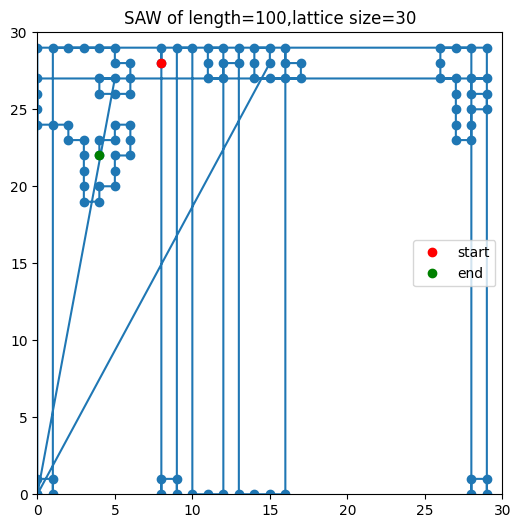

In [48]:
N = 4 # num of sample
D = 100 # length of walk
L = 30 # size of lattice
[allwalkpath,ww] = SAW(D,N,L)

X = allwalkpath[:,2,0]
Y = allwalkpath[:,2,1]
res = generate_walk_plot(X,Y,L)


#### the expected number of times a lattice site is visited (this should be the same for every site)

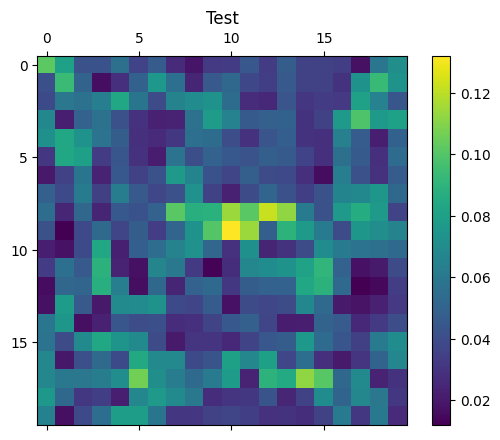

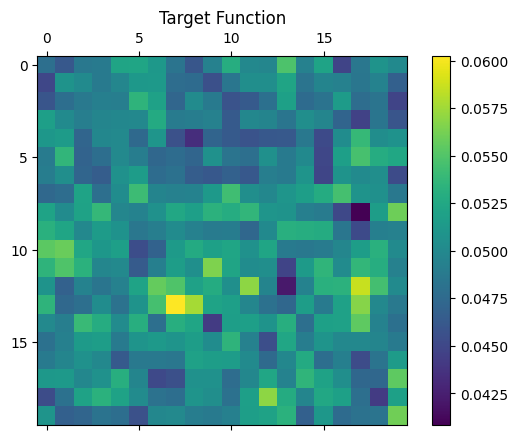

In [50]:
N = 10000 # num of sample
D = 100
L = 20

# test case
[allwalkpath,ww] = SAW(D,N,L)
allwalkpath = allwalkpath.astype(int)
density = np.zeros((L,L))
for n in range(N):
    path = allwalkpath[:,n,:]
    for pos in path:
        density[pos[0],pos[1]] += ww[n]
density /= sum(density) # normalizing it

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(density)
plt.title('Test')
fig.colorbar(cax)
plt.show()


# target function
[allwalkpath,ww] = SAW(D,N,L,flag=1)
allwalkpath = allwalkpath.astype(int)
density = np.zeros((L,L))
for n in range(N):
    path = allwalkpath[:,n,:]
    for pos in path:
        density[pos[0],pos[1]] += ww[n]
density /= sum(density) # normalizing it

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(density)
plt.title('Target Function')
fig.colorbar(cax)
plt.show()

#### estimation of normalizing constant $\mathcal{Z}_d$

In [51]:
def SAW_revised(D,N,L,flag=0):
    """
    D   :   length of walk (D step total)
    N   :   number of samples
    L   :   length of lattice
    flag:   whether or not resampling
    Return: saw with length D and corresponding weight ([s_i],[w_i])
    """
    # auxiliary functions registeration
    def systematic_2(W):
        N = len(W)
        cW = np.cumsum(W)
        uu = (np.random.random()+np.arange(N))/N
        indd = np.zeros(N,'i')
        i = 0
        j = 0
        while i < N:
            if uu[i] < cW[j]:
                indd[i] = j
                i += 1
            else:
                j += 1
        return indd   

    def repeat(newpp,hist):
        '''
        pp  :   new point proposal
        hist:   dynamically updated history of SAW
        Return: True/False whether the SAW with the newly added point is eligible
        '''
        for pp in hist:
            if np.sum(np.abs(pp-newpp)) <= 0.5:
                return True
        return False

    # =========================================================
    # =========================================================
    # start the function
    allwalkpath = np.zeros((D,N,2))
    weight = np.zeros(N)
    Z_lst = np.zeros(D)
    Z_lst[0] = np.square(L)

    allwalkpath[0,:,:] = np.random.randint(0,L,size=(N,2))
    
    # generate uniform weight
    ww = np.ones(N)/N
    poss_mov = np.array([(1,0), (0,1), (-1,0), (0,-1)])

    for d in range(1,D):
        # count move for each sample
        M = 0
        for n in range(N):
            cnt = 0
            curr = allwalkpath[d-1,n,:]
            ppp_lst = []
            for move in poss_mov:
                # in case out of boundary
                pp = (curr+move)%L 
                if not repeat(pp,allwalkpath[:d,n,:]):
                    cnt += 1
                    M += 1
                    ppp_lst.append(pp)
            if cnt >= 1:
                allwalkpath[d,n,:] = ppp_lst[np.random.randint(len(ppp_lst))]
            ww[n] *= cnt
        assert np.sum(ww) > 0
        ww /= np.sum(ww)

        if flag != 0:
            res = systematic_2(ww)
            ccppy = copy.deepcopy(allwalkpath)
            for i in range(len(res)):
                allwalkpath[:,i,:] = ccppy[:,res[i],:]
            ww = np.ones(N)/N

        Z_lst[d] = Z_lst[d-1]*M/N
        
    return Z_lst

#### Experiment

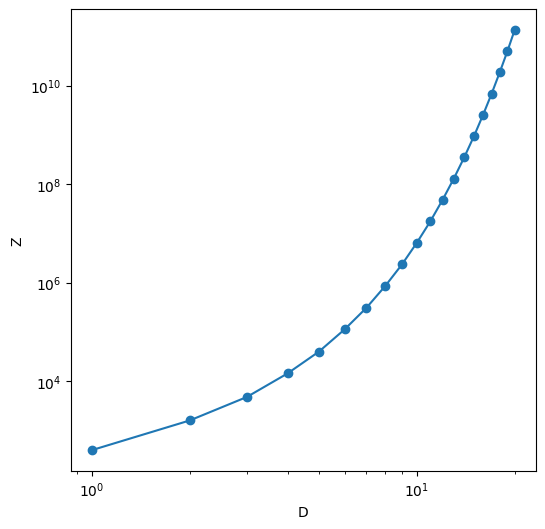

In [53]:
D = 20
N = 10000
L = 20

Z_lst = SAW_revised(D, N, L, flag = 1)
D_lst = [i for i in range(1,D+1)]

plt.figure(figsize=(6,6))
plt.plot(D_lst,Z_lst,'o-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('D')
plt.ylabel('Z')
plt.show()